In [ ]:
import pandas as pd
import re
from dateutil import parser

# Load csv's
df_t = pd.read_csv('/content/True.csv')
df_f = pd.read_csv('/content/Fake.csv')

# Convert datetime to useable format
df_t['date'] = pd.to_datetime(df_t['date'], errors='coerce')
df_f['date'] = pd.to_datetime(df_f['date'], errors='coerce')

print("Invalid date count before recovery:", df_f['date'].isna().sum())

def clean_date(row):
    if pd.notna(row['date']):
        return row['date']
    match = re.search(r'([A-Z][a-z]+\s+\d{1,2},?\s+\d{4})', row['text'].strip())
    if match:
        try:
            return parser.parse(match.group(1))
        except Exception:
            return pd.NaT
    return pd.NaT

df_f.loc[:, 'date'] = df_f.apply(clean_date, axis=1)

# Check invalid entries
print("Invalid date count after recovery:", df_f['date'].isna().sum())

# Add targets for supervised learning (needs to be encoded)
df_t['target'] = 'real'
df_f['target'] = 'fake'

df = pd.concat([df_t, df_f], ignore_index=True)

# Gather numeric date features into distinct pieces of information
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['dayofyear'] = df['date'].dt.dayofyear

df['target'].value_counts()

Invalid date count before recovery: 11613
Invalid date count after recovery: 8667


,count
target,
fake,23481
real,21417


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Filter for 2016-2017 data only using existing year column
print(f"Rows before year filtering: {len(df)}")
df = df[df['year'].isin([2016, 2017])].reset_index(drop=True)
print(f"Rows after filtering for 2016-2017: {len(df)}")

# Remove duplicates based on title and text
print(f"Rows before duplicate removal: {len(df)}")
df = df.drop_duplicates(subset=['title', 'text'], keep='first').reset_index(drop=True)
print(f"Rows after removing duplicates: {len(df)}")

# Get rid of NaT, NaN, and other missing critical data
print(f"Rows before cleaning missing values: {len(df)}")
df = df.dropna(subset=['date', 'title', 'text']).reset_index(drop=True)
print(f"Rows after cleaning missing values: {len(df)}")

le_subject = LabelEncoder()
le_target = LabelEncoder()

df.loc[:, 'subject_encoded'] = le_subject.fit_transform(df['subject'])
df.loc[:, 'target_encoded'] = le_target.fit_transform(df['target'])

# Enhanced TF-IDF for title with better parameters
title_vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words='english',
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 2)
)
title_tfidf = title_vectorizer.fit_transform(df['title'])
print("Title TF-IDF shape:", title_tfidf.shape)

# Enhanced TF-IDF for text with optimized parameters for longer content
text_vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=5,
    max_df=0.95,
    ngram_range=(1, 2),
    sublinear_tf=True
)
text_tfidf = text_vectorizer.fit_transform(df['text'])
print("Text TF-IDF shape:", text_tfidf.shape)

Rows before year filtering: 44898
Rows after filtering for 2016-2017: 35376
Rows before duplicate removal: 35376
Rows after removing duplicates: 33054
Rows before cleaning missing values: 33054
Rows after cleaning missing values: 33054
Title TF-IDF shape: (33054, 500)
Text TF-IDF shape: (33054, 10000)


In [ ]:
from scipy.sparse import hstack

# Ensure both matrices have the same number of rows
assert title_tfidf.shape[0] == text_tfidf.shape[0], "Feature matrices must have same number of rows"

X_text = hstack([title_tfidf, text_tfidf])

print(f"Combined text features shape: {X_text.shape}")
print(f"Total text features: {title_tfidf.shape[1]} (title) + {text_tfidf.shape[1]} (text) = {X_text.shape[1]}")
print(f"Memory usage: {X_text.data.nbytes / 1024 / 1024:.2f} MB")

Combined text features shape: (33054, 10500)
Total text features: 500 (title) + 10000 (text) = 10500
Memory usage: 40.38 MB


In [ ]:
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select numeric features (handle potential NaN values)
numeric_features = ['year', 'month', 'day', 'dayofweek']
X_numeric = df[numeric_features].fillna(0)  # Fill NaN with 0 or use median

print(f"Numeric features shape: {X_numeric.shape}")
print(f"Numeric features: {numeric_features}")

# Scale numeric features for better model performance
scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Convert to sparse matrix for memory efficiency
X_numeric_sparse = csr_matrix(X_numeric_scaled)

# Combine all features: text + numeric
print(f"Text features shape: {X_text.shape}")
print(f"Numeric features shape: {X_numeric_sparse.shape}")

X = hstack([X_text, X_numeric_sparse])
y = df['target_encoded']

# Final feature matrix summary
print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature breakdown:")
print(f"  - Text features (title + text TF-IDF): {X_text.shape[1]}")
print(f"  - Numeric features (scaled): {X_numeric_sparse.shape[1]}")
print(f"  - Total features: {X.shape[1]}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Memory usage: {X.data.nbytes / 1024 / 1024:.2f} MB")

Numeric features shape: (33054, 4)
Numeric features: ['year', 'month', 'day', 'dayofweek']
Text features shape: (33054, 10500)
Numeric features shape: (33054, 4)

Final feature matrix shape: (33054, 10504)
Feature breakdown:
  - Text features (title + text TF-IDF): 10500
  - Numeric features (scaled): 4
  - Total features: 10504
Target distribution: [11857 21197]
Memory usage: 41.39 MB


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Train-test split with better parameters
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Validate the split
print("Dataset split summary:")
print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")

print(f"\nClass distribution:")
print("Training set:")
train_counts = np.bincount(y_train)
for i, count in enumerate(train_counts):
    print(f"  Class {i}: {count} ({count/len(y_train)*100:.1f}%)")

print("Test set:")
test_counts = np.bincount(y_test)
for i, count in enumerate(test_counts):
    print(f"  Class {i}: {count} ({count/len(y_test)*100:.1f}%)")

print(f"\nSplit ratio: {len(y_train)/(len(y_train)+len(y_test))*100:.1f}% train, {len(y_test)/(len(y_train)+len(y_test))*100:.1f}% test")

Dataset split summary:
Training set: 26443 samples, 10504 features
Test set: 6611 samples, 10504 features

Class distribution:
Training set:
  Class 0: 9486 (35.9%)
  Class 1: 16957 (64.1%)
Test set:
  Class 0: 2371 (35.9%)
  Class 1: 4240 (64.1%)

Split ratio: 80.0% train, 20.0% test


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000,class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9962184238390561
Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      2371
           1       1.00      1.00      1.00      4240

    accuracy                           1.00      6611
   macro avg       1.00      1.00      1.00      6611
weighted avg       1.00      1.00      1.00      6611



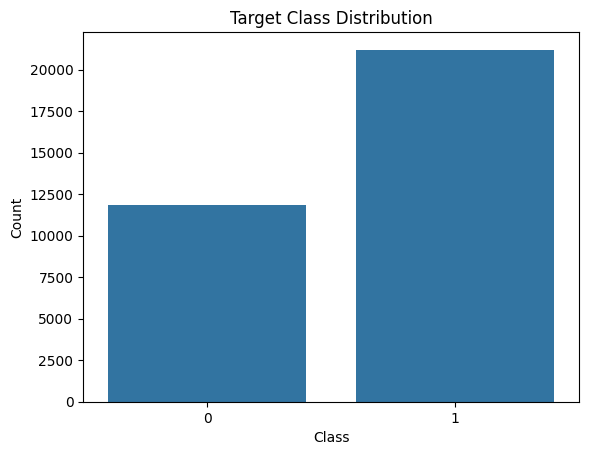

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['target_encoded'])
plt.title("Target Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

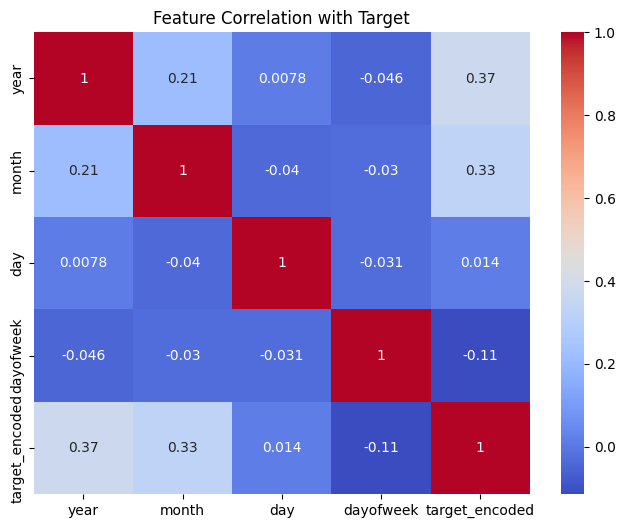

In [ ]:
# Add target to your numeric features temporarily for this
correlation = df[['year', 'month', 'day', 'dayofweek', 'target_encoded']].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Target")
plt.show()

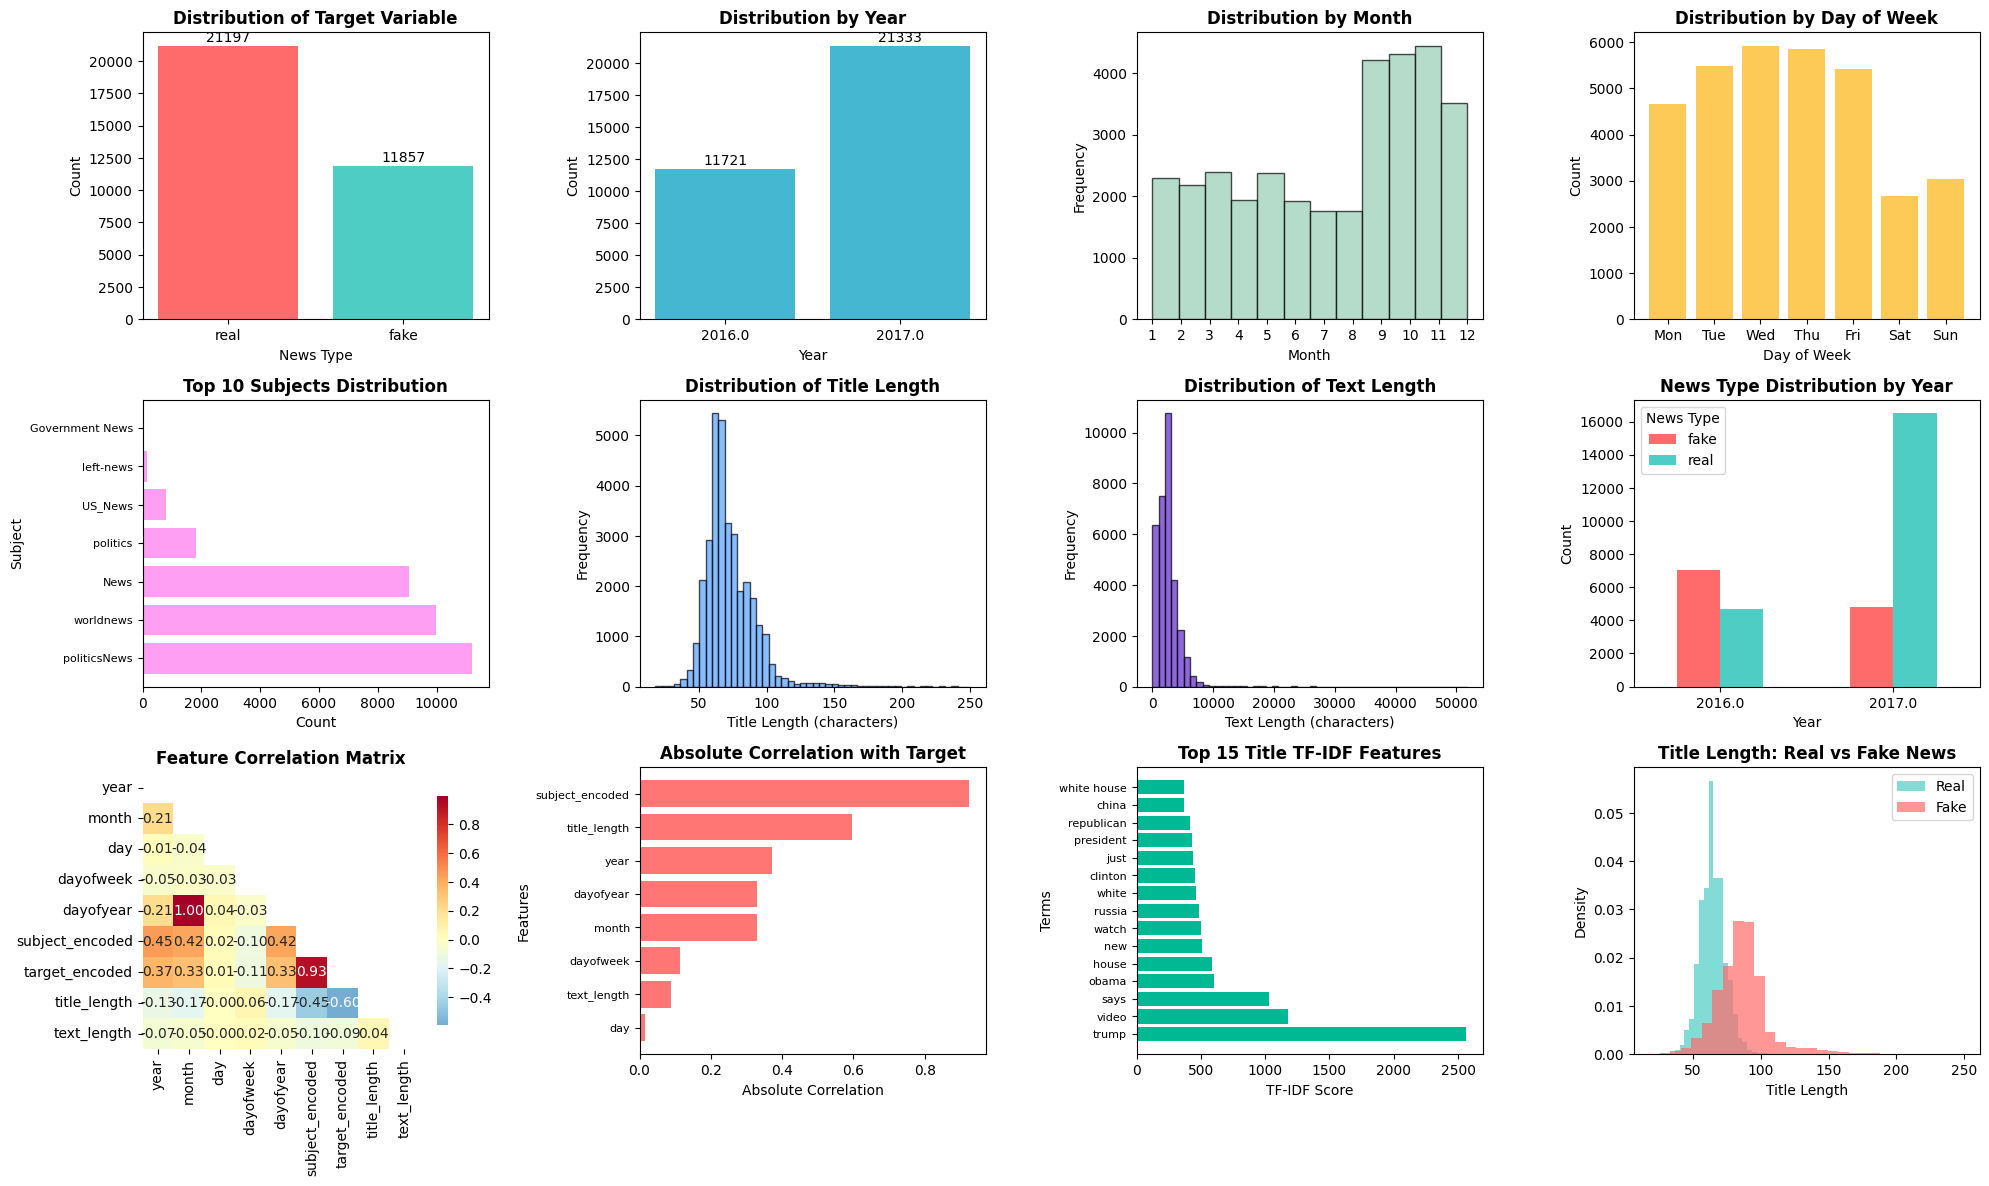

FEATURE ANALYSIS SUMMARY
Total samples: 33054
Real news: 21197 (64.1%)
Fake news: 11857 (35.9%)
Years covered: 2016.0 - 2017.0
Number of unique subjects: 7
Average title length: 72.6 characters
Average text length: 2501.2 characters

Top correlations with target variable:
  subject_encoded: 0.926
  title_length: 0.596
  year: 0.372
  dayofyear: 0.329
  month: 0.329


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.sparse import hstack
import pandas as pd

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive analysis of features
def analyze_features_and_correlations(df, title_tfidf, text_tfidf, le_subject, le_target):
    """
    Create histograms for feature distributions and correlation analysis
    """

    # Set up the figure with multiple subplots
    fig = plt.figure(figsize=(20,12))

    # 1. Distribution of target variable
    plt.subplot(3, 4, 1)
    target_counts = df['target'].value_counts()
    plt.bar(target_counts.index, target_counts.values, color=['#ff6b6b', '#4ecdc4'])
    plt.title('Distribution of Target Variable', fontsize=12, fontweight='bold')
    plt.xlabel('News Type')
    plt.ylabel('Count')
    for i, v in enumerate(target_counts.values):
        plt.text(i, v + 100, str(v), ha='center', va='bottom')

    # 2. Distribution of years
    plt.subplot(3, 4, 2)
    year_counts = df['year'].value_counts().sort_index()
    plt.bar(year_counts.index.astype(str), year_counts.values, color='#45b7d1')
    plt.title('Distribution by Year', fontsize=12, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Count')
    for i, (year, count) in enumerate(year_counts.items()):
        plt.text(i, count + 50, str(count), ha='center', va='bottom')

    # 3. Distribution of months
    plt.subplot(3, 4, 3)
    month_counts = df['month'].value_counts().sort_index()
    plt.hist(df['month'], bins=12, color='#96ceb4', alpha=0.7, edgecolor='black')
    plt.title('Distribution by Month', fontsize=12, fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Frequency')
    plt.xticks(range(1, 13))

    # 4. Distribution of day of week
    plt.subplot(3, 4, 4)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    dow_counts = df['dayofweek'].value_counts().sort_index()
    plt.bar(range(7), dow_counts.values, color='#feca57')
    plt.title('Distribution by Day of Week', fontsize=12, fontweight='bold')
    plt.xlabel('Day of Week')
    plt.ylabel('Count')
    plt.xticks(range(7), days)

    # 5. Distribution of subjects
    plt.subplot(3, 4, 5)
    subject_counts = df['subject'].value_counts().head(10)
    plt.barh(range(len(subject_counts)), subject_counts.values, color='#ff9ff3')
    plt.title('Top 10 Subjects Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel('Subject')
    plt.yticks(range(len(subject_counts)), subject_counts.index, fontsize=8)

    # 6. Title length distribution
    plt.subplot(3, 4, 6)
    df['title_length'] = df['title'].str.len()
    plt.hist(df['title_length'], bins=50, color='#54a0ff', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Title Length', fontsize=12, fontweight='bold')
    plt.xlabel('Title Length (characters)')
    plt.ylabel('Frequency')

    # 7. Text length distribution
    plt.subplot(3, 4, 7)
    df['text_length'] = df['text'].str.len()
    plt.hist(df['text_length'], bins=50, color='#5f27cd', alpha=0.7, edgecolor='black')
    plt.title('Distribution of Text Length', fontsize=12, fontweight='bold')
    plt.xlabel('Text Length (characters)')
    plt.ylabel('Frequency')

    # 8. Target vs Year cross-tabulation
    plt.subplot(3, 4, 8)
    crosstab = pd.crosstab(df['year'], df['target'])
    crosstab.plot(kind='bar', ax=plt.gca(), color=['#ff6b6b', '#4ecdc4'])
    plt.title('News Type Distribution by Year', fontsize=12, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(title='News Type')
    plt.xticks(rotation=0)

    # 9-12. Create correlation matrix for numerical features
    # Combine all features for correlation analysis
    numerical_features = df[['year', 'month', 'day', 'dayofweek', 'dayofyear',
                           'subject_encoded', 'target_encoded', 'title_length', 'text_length']]

    # 9. Correlation heatmap
    plt.subplot(3, 4, 9)
    corr_matrix = numerical_features.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

    # 10. Target correlation with other features
    plt.subplot(3, 4, 10)
    target_corr = numerical_features.corr()['target_encoded'].drop('target_encoded').abs().sort_values(ascending=True)
    plt.barh(range(len(target_corr)), target_corr.values, color='#ff7675')
    plt.title('Absolute Correlation with Target', fontsize=12, fontweight='bold')
    plt.xlabel('Absolute Correlation')
    plt.ylabel('Features')
    plt.yticks(range(len(target_corr)), target_corr.index, fontsize=8)

    # 11. TF-IDF feature importance (top terms from title)
    plt.subplot(3, 4, 11)
    feature_names = title_vectorizer.get_feature_names_out()
    tfidf_scores = np.array(title_tfidf.sum(axis=0)).flatten()
    top_indices = tfidf_scores.argsort()[-15:][::-1]
    top_features = [feature_names[i] for i in top_indices]
    top_scores = [tfidf_scores[i] for i in top_indices]

    plt.barh(range(len(top_features)), top_scores, color='#00b894')
    plt.title('Top 15 Title TF-IDF Features', fontsize=12, fontweight='bold')
    plt.xlabel('TF-IDF Score')
    plt.ylabel('Terms')
    plt.yticks(range(len(top_features)), top_features, fontsize=8)

    # 12. Distribution comparison: Real vs Fake news characteristics
    plt.subplot(3, 4, 12)
    real_title_len = df[df['target'] == 'real']['title_length']
    fake_title_len = df[df['target'] == 'fake']['title_length']

    plt.hist(real_title_len, bins=30, alpha=0.7, label='Real', color='#4ecdc4', density=True)
    plt.hist(fake_title_len, bins=30, alpha=0.7, label='Fake', color='#ff6b6b', density=True)
    plt.title('Title Length: Real vs Fake News', fontsize=12, fontweight='bold')
    plt.xlabel('Title Length')
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("="*60)
    print("FEATURE ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total samples: {len(df)}")
    print(f"Real news: {len(df[df['target'] == 'real'])} ({len(df[df['target'] == 'real'])/len(df)*100:.1f}%)")
    print(f"Fake news: {len(df[df['target'] == 'fake'])} ({len(df[df['target'] == 'fake'])/len(df)*100:.1f}%)")
    print(f"Years covered: {df['year'].min()} - {df['year'].max()}")
    print(f"Number of unique subjects: {df['subject'].nunique()}")
    print(f"Average title length: {df['title_length'].mean():.1f} characters")
    print(f"Average text length: {df['text_length'].mean():.1f} characters")

    print("\nTop correlations with target variable:")
    target_corr_sorted = numerical_features.corr()['target_encoded'].drop('target_encoded').abs().sort_values(ascending=False)
    for feature, corr in target_corr_sorted.head(5).items():
        print(f"  {feature}: {corr:.3f}")
# Call the analysis function
analyze_features_and_correlations(df, title_tfidf, text_tfidf, le_subject, le_target)

Looks like there is very high corelation between subject_encoded and target_encoded, will rerun the model without subject_encoded.
We can also see high feature corelation between dayofyear and month

Decision Tree analysis

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def create_decision_tree_with_text_features(df, title_tfidf, text_tfidf, numeric_features):
    """
    Create and evaluate decision tree with combined numeric and text features
    """
    print("\n" + "="*60)
    print("TRAINING DECISION TREE CLASSIFIER")
    print("="*60)

    # Decision tree with optimized parameters
    dt_classifier = DecisionTreeClassifier(
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced'
    )

    dt_classifier.fit(X_train, y_train)

    y_pred_train = dt_classifier.predict(X_train)
    y_pred_test = dt_classifier.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Overfitting Check: {train_accuracy - test_accuracy:.4f}")

    cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

    print("\n" + "="*60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*60)

    feature_importance = dt_classifier.feature_importances_

    numeric_feature_names = numeric_features
    title_feature_names = [f"title_{name}" for name in title_vectorizer.get_feature_names_out()]
    text_feature_names = [f"text_{name}" for name in text_vectorizer.get_feature_names_out()]
    all_feature_names = numeric_feature_names + title_feature_names + text_feature_names

    top_indices = np.argsort(feature_importance)[-10:][::-1]
    top_features = [all_feature_names[i] for i in top_indices]
    top_importance = [feature_importance[i] for i in top_indices]

    print("Top 10 Most Important Features:")
    for feature, importance in zip(top_features, top_importance):
        print(f"  {feature}: {importance:.4f}")

    numeric_importance = feature_importance[:len(numeric_features)]
    title_importance = feature_importance[len(numeric_features):len(numeric_features)+title_tfidf.shape[1]]
    text_importance = feature_importance[len(numeric_features)+title_tfidf.shape[1]:]

    print(f"\nNumeric features total importance: {numeric_importance.sum():.4f}")
    print(f"Title TF-IDF total importance: {title_importance.sum():.4f}")
    print(f"Text TF-IDF total importance: {text_importance.sum():.4f}")



    # Classification Report
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print("Test Set Results:")
    print(classification_report(y_test, y_pred_test,
                              target_names=['Fake', 'Real'], digits=4))

    # Decision Tree Visualization (simplified version)
    plt.figure(figsize=(25, 15))
    plot_tree(dt_classifier,
              max_depth=3,
              filled=True,
              feature_names=all_feature_names,
              class_names=['Fake', 'Real'],
              fontsize=10)
    plt.title('Decision Tree (Top 3 Levels)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return dt_classifier, X_test, y_test, y_pred_test, feature_importance, all_feature_names


TRAINING DECISION TREE CLASSIFIER
Training Accuracy: 0.9083
Test Accuracy: 0.9017
Overfitting Check: 0.0067
Cross-validation scores: [0.87407828 0.88958215 0.88750236 0.91698185 0.91509077]
Average CV score: 0.8966 (+/- 0.0334)

FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
  text_safe: 0.4750
  text_feared: 0.2423
  title_urges: 0.0320
  text_twist: 0.0312
  text_don need: 0.0158
  text_pocket: 0.0140
  text_web: 0.0139
  text_tweeting: 0.0123
  text_reuters news: 0.0123
  text_semi: 0.0111

Numeric features total importance: 0.0000
Title TF-IDF total importance: 0.0378
Text TF-IDF total importance: 0.9622

DETAILED CLASSIFICATION REPORT
Test Set Results:
              precision    recall  f1-score   support

        Fake     0.8261    0.9194    0.8703      2371
        Real     0.9519    0.8917    0.9208      4240

    accuracy                         0.9017      6611
   macro avg     0.8890    0.9056    0.8956      6611
weighted avg     0.9068    0.9017    0.9027     

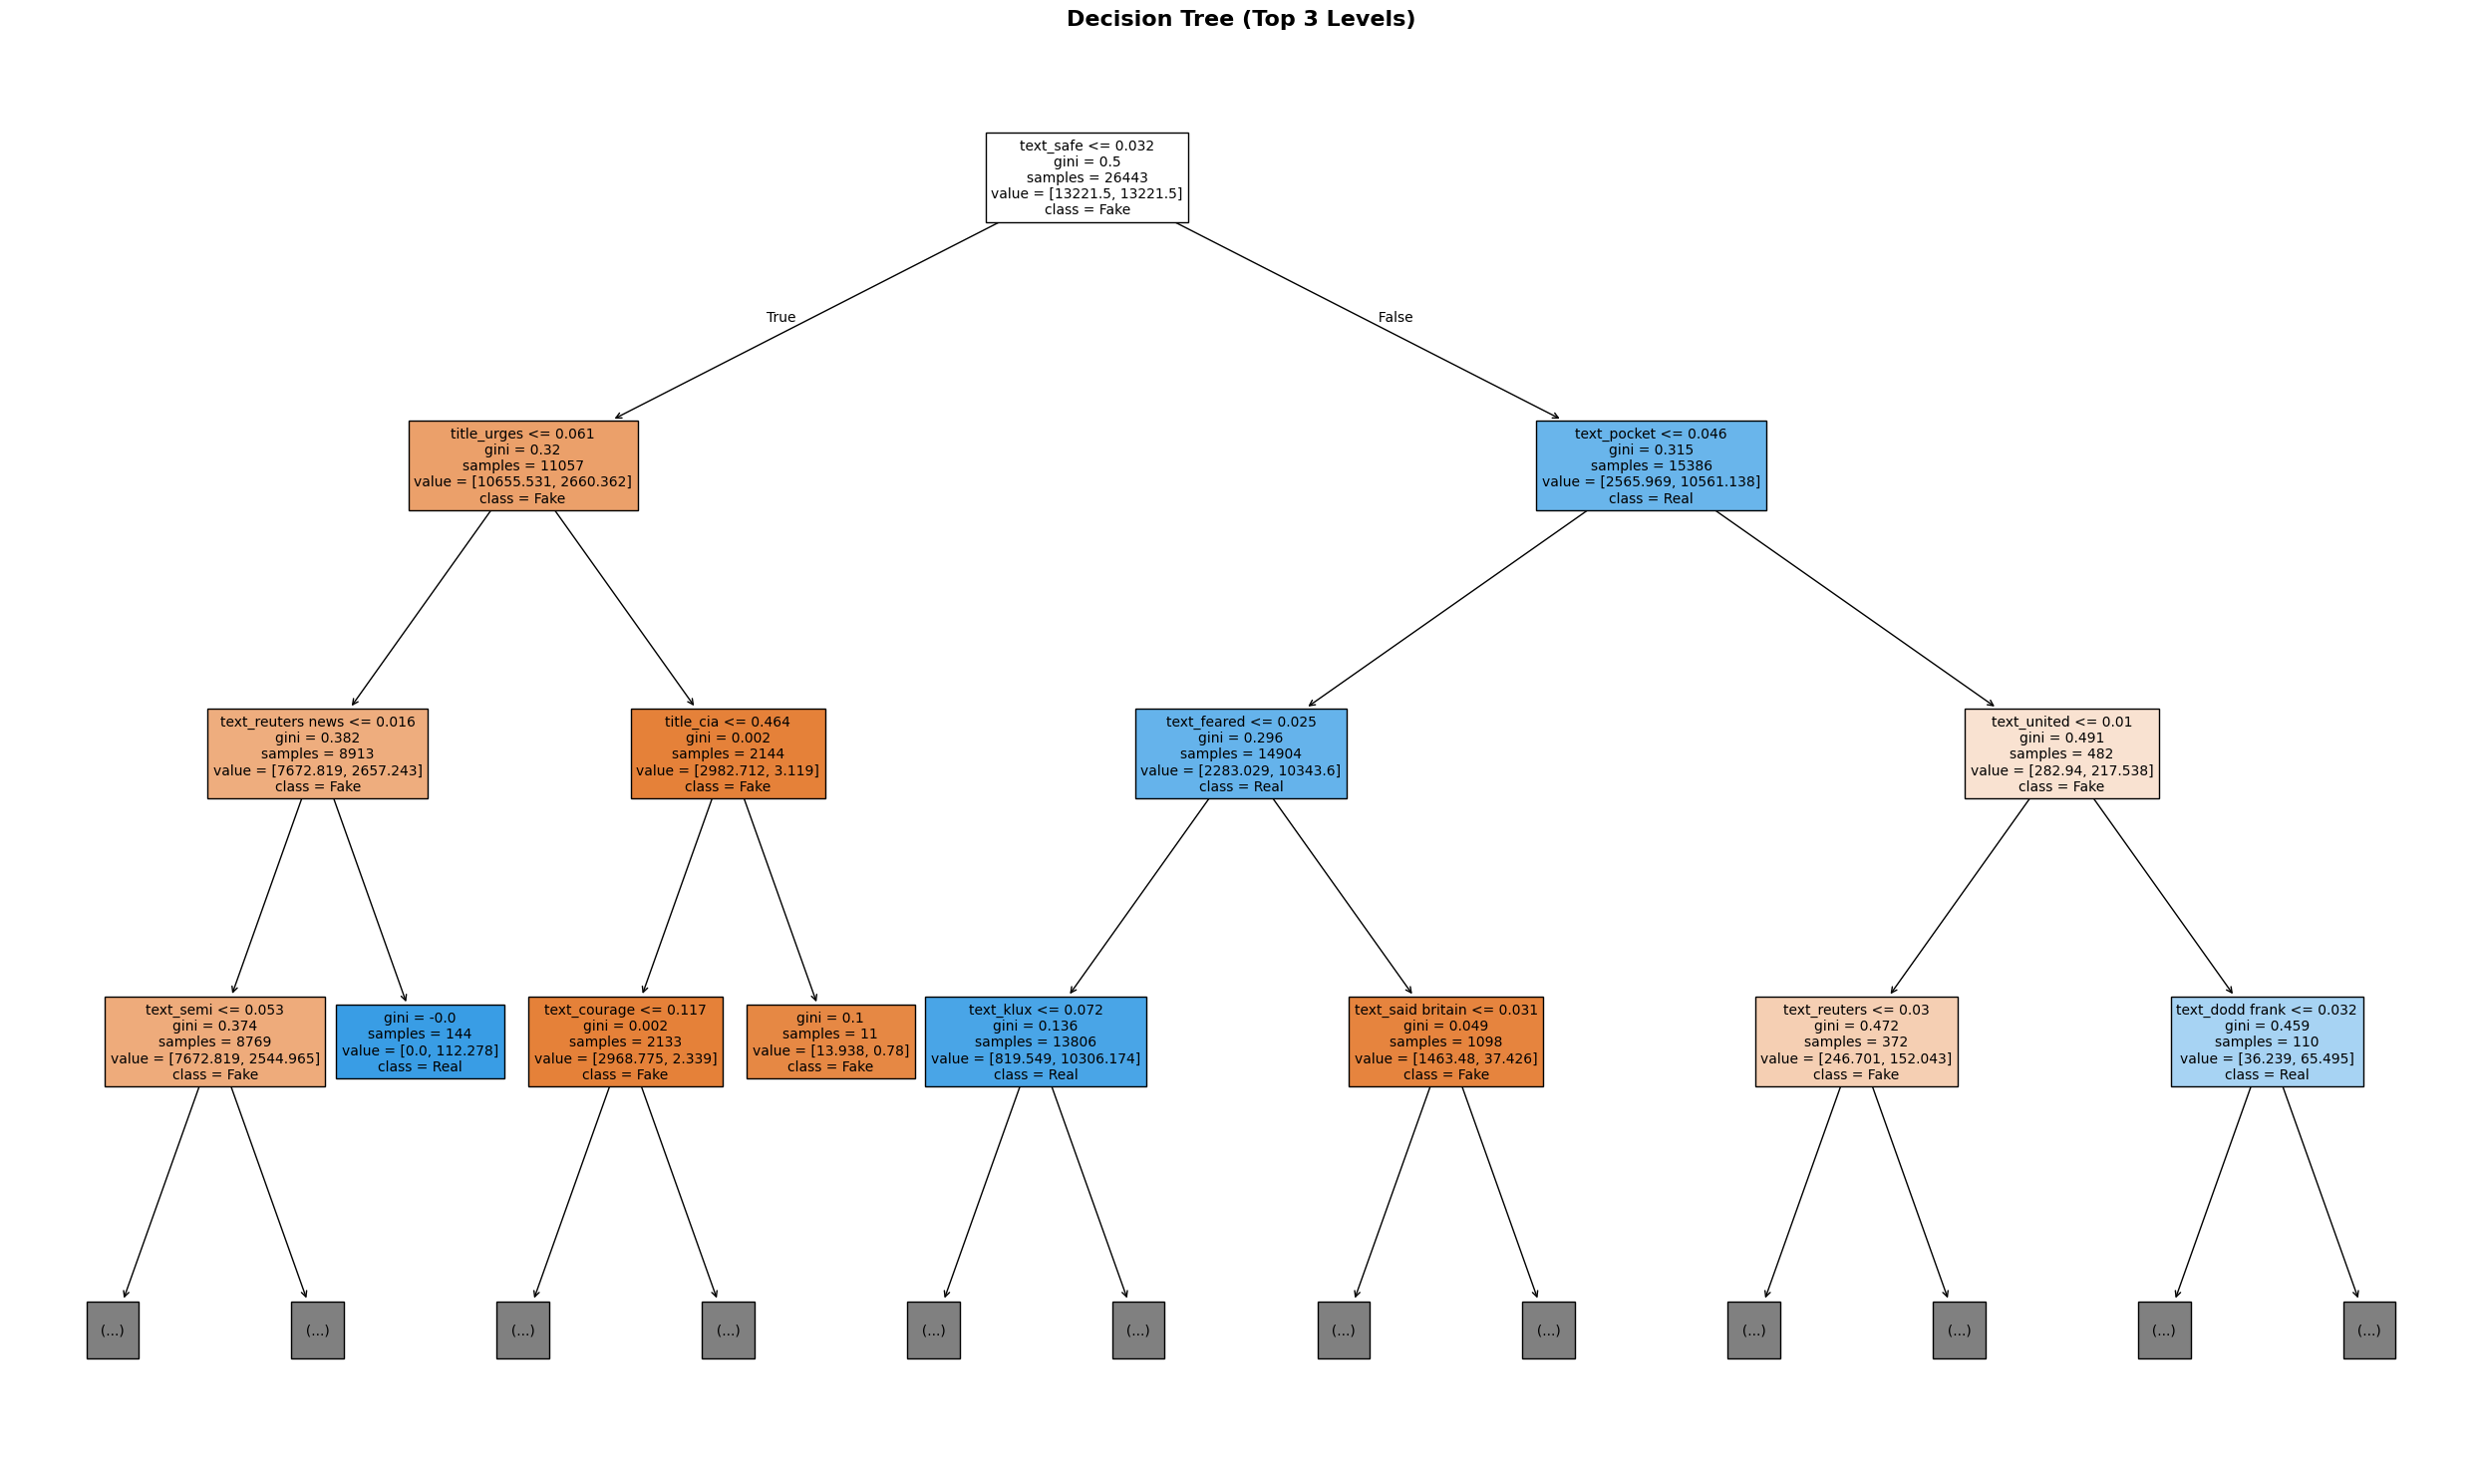

In [ ]:
numeric_features = ['year', 'month', 'day', 'dayofweek']

# Execute the decision tree analysis
dt_model, X_test, y_test, y_pred, importance, feature_names = create_decision_tree_with_text_features(
    df, title_tfidf, text_tfidf, numeric_features
)

Trying to check whats the reason behind 100% accuracy


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


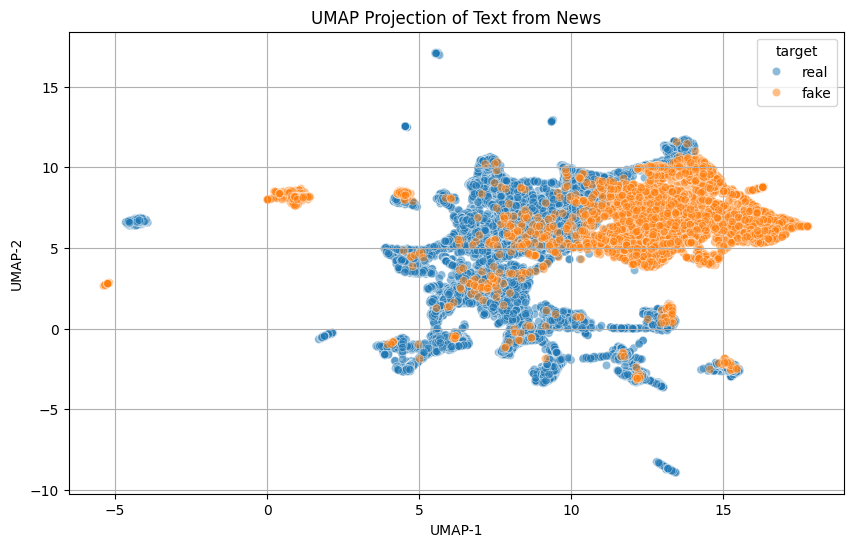

In [ ]:
# Reduce dimensions and project to 2D representation for unsupervised analysis
# of text in articles

from sklearn.decomposition import TruncatedSVD
import umap.umap_ as umap

# Dimension reduction
svd = TruncatedSVD(n_components=30, random_state=5)
# Apply transform to text
text_svd = svd.fit_transform(text_tfidf)

# Project to 2D with UMAP
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1, random_state=10)
text_umap = umap_model.fit_transform(text_svd)

# Create a UMAP dataframe
umap_df = pd.DataFrame(text_umap, columns=["UMAP-1", "UMAP-2"])
# Add labels for later validation
umap_df["target"] = df["target"]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=umap_df, x="UMAP-1", y="UMAP-2", hue="target", alpha=0.5, palette="tab10") # colorblind friendly
plt.title("UMAP Projection of Text from News")
plt.grid(True)
plt.show()

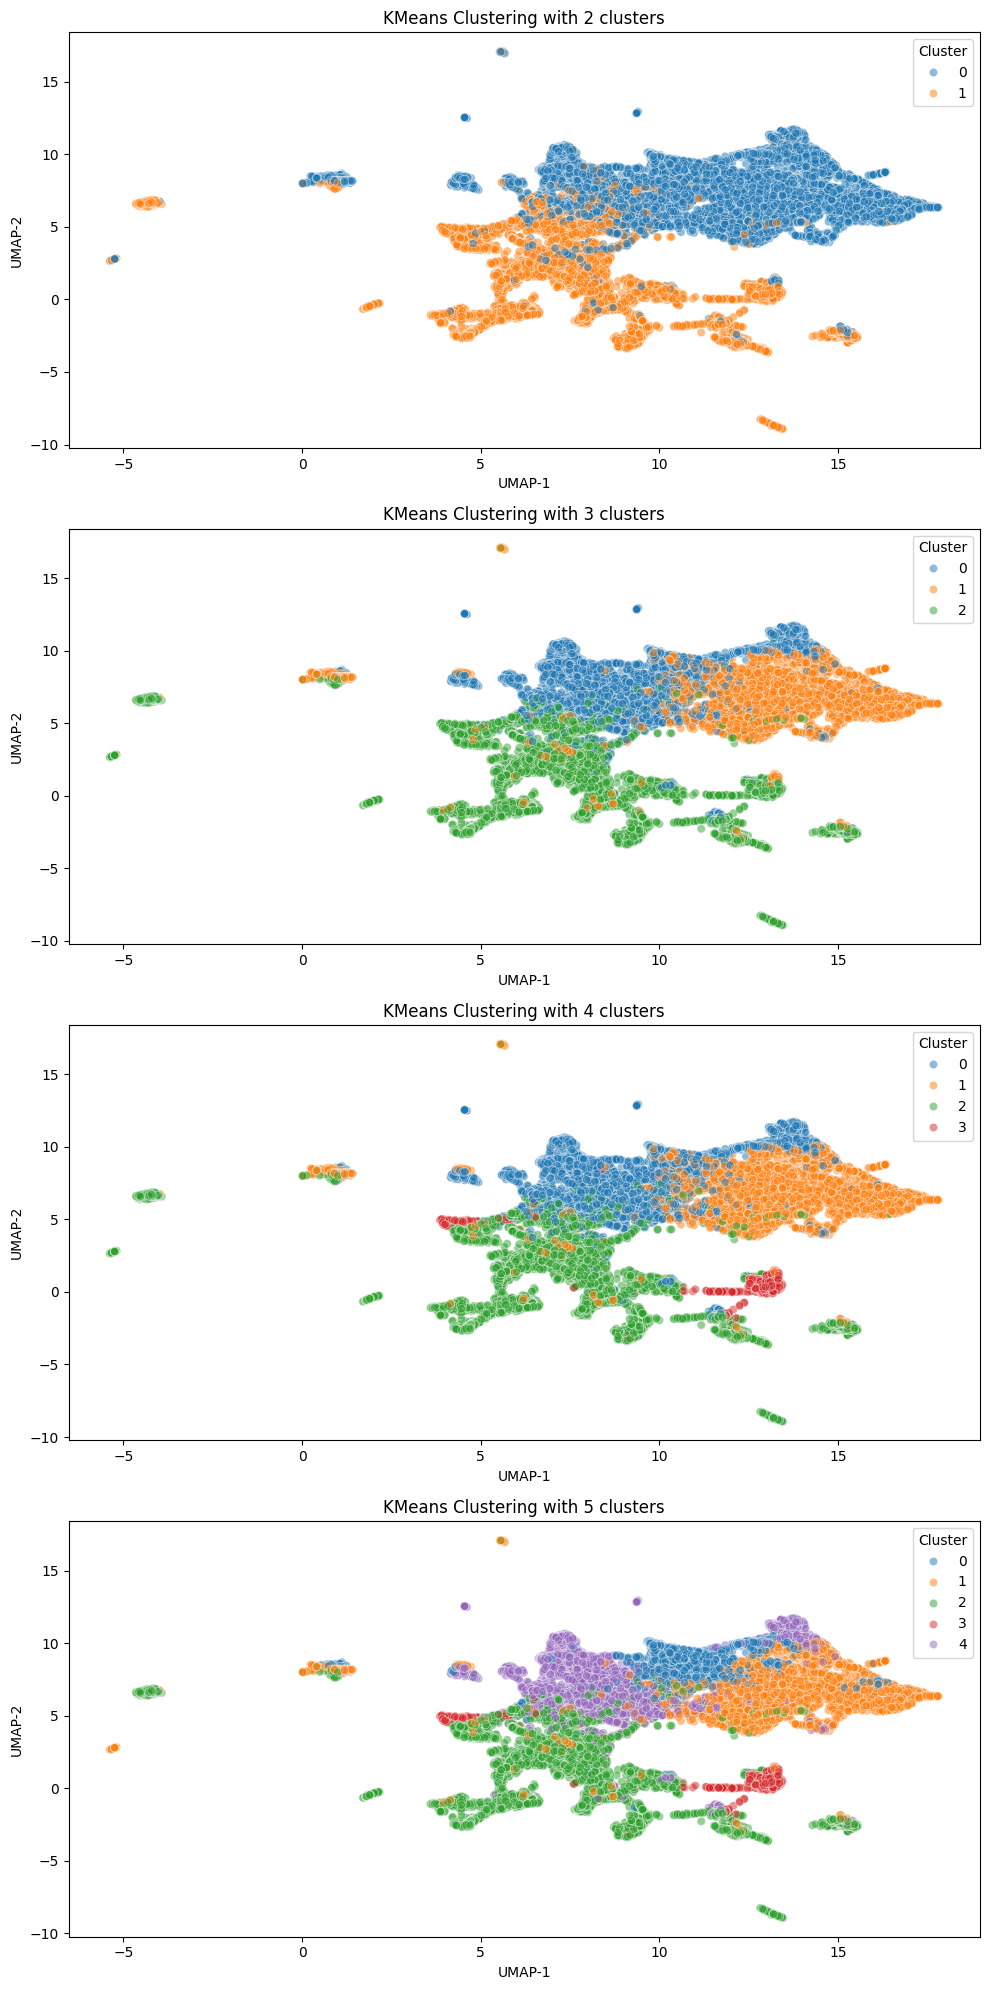

In [ ]:
# Clustering (KMeans, k=2,3,4,5)

from sklearn.cluster import KMeans

# Try different cluster amounts (Agglomerative not as useful due to large dataset)
fig, axes = plt.subplots(4, 1, figsize=(10, 20))

for i, k in enumerate(range(2, 6)):
    kmeans = KMeans(n_clusters=k, random_state=5, n_init='auto')
    kmeans_labels = kmeans.fit_predict(text_svd)

    # Add KMeans feature
    umap_df["KMeans Cluster"] = kmeans_labels

    # Plot
    ax = axes[i]
    sns.scatterplot(data=umap_df, x="UMAP-1", y="UMAP-2", hue="KMeans Cluster", palette="tab10", alpha=0.5, ax=ax) # colorblind friendly
    ax.set_title(f"KMeans Clustering with {k} clusters")
    ax.legend(title="Cluster")

plt.tight_layout()
plt.show()

In [ ]:
# Map similar subjects to equivalent subjects
subjects = {
    'politics': 'Politics',
    'politicsNews': 'Politics',
    'left-news': 'Politics',
    'US_News': 'US & Government',
    'Government News': 'US & Government',
    'worldnews': 'World News',
    'News': 'World News'
}

df['subject'] = df['subject'].map(subjects)
print("Equivalent subjects:", df['subject'].unique())

Equivalent subjects: ['Politics' 'World News' 'US & Government']


In [ ]:
# Compare clustering with known targets and give purely unsupervised evaluation
from sklearn.metrics import silhouette_score

res = {}

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(text_svd)

    # Unsupervised metrics as well
    inertia = kmeans.inertia_
    sil = silhouette_score(text_svd, labels)

    df_clustered = df[['subject', 'target']].copy()
    df_clustered['cluster'] = labels

    # Cross-tabulation for subject and target (kmeans values chosen to reflect these structural features)
    subject_ct = pd.crosstab(df_clustered['cluster'], df_clustered['subject'], normalize='index')
    target_ct = pd.crosstab(df_clustered['cluster'], df_clustered['target'], normalize='index')

    res[k] = {'subject_alignment': subject_ct, 'target_alignment': target_ct, 'inertia': inertia, 'silhouette': sil}

    print(f"KMeans - {k} Clusters vs. Subject")
    print(subject_ct)
    print(f"KMeans - {k} Clusters vs Target")
    print(target_ct)

    print(f"KMeans - {k} Clusters")
    print(f"  Inertia: {inertia:.3f}, Silhouette: {sil:.3f}")

KMeans - 2 Clusters vs. Subject
subject  Politics  US & Government  World News
cluster                                       
0        0.475854         0.017624    0.506522
1        0.279380         0.037708    0.682912
KMeans - 2 Clusters vs Target
target       fake      real
cluster                    
0        0.039630  0.960370
1        0.852946  0.147054
KMeans - 2 Clusters
  Inertia: 2727.912, Silhouette: 0.076
KMeans - 3 Clusters vs. Subject
subject  Politics  US & Government  World News
cluster                                       
0        0.647626         0.016192    0.336181
1        0.191030         0.042540    0.766430
2        0.224008         0.017717    0.758275
KMeans - 3 Clusters vs Target
target       fake      real
cluster                    
0        0.063047  0.936953
1        0.951954  0.048046
2        0.030628  0.969372
KMeans - 3 Clusters
  Inertia: 2591.431, Silhouette: 0.075
KMeans - 4 Clusters vs. Subject
subject  Politics  US & Government  World News
clus

In [ ]:
# Find top words in text to see cluster 'top 10 words' composition

def top_words(model, tfidf, n_top=10):
    # Sort words in descending order
    i_word = model.cluster_centers_.argsort()[:, ::-1]
    # Map to actual words from indices
    words = tfidf.get_feature_names_out()
    top_words = {}

    for i in range(model.n_clusters):
        top_words[i] = [words[id] for id in i_word[i, :n_top]]

    return top_words

# Grab top 10 words for each clustering size
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=10, n_init='auto')
    kmeans.fit(text_tfidf)

    word_list = top_words(kmeans, text_vectorizer, n_top=10)
    print(f"Top words for cluster size {k}")

    for i, word in word_list.items():
        print(f"Cluster {i}: {' - '.join(word)}")

Top words for cluster size 2
Cluster 0: trump - just - people - donald - image - clinton - like - donald trump - twitter - featured
Cluster 1: said - reuters - president - trump - government - state - washington - united - house - told
Top words for cluster size 3
Cluster 0: trump - just - image - people - like - featured - featured image - twitter - donald - donald trump
Cluster 1: trump - said - house - republican - washington - washington reuters - president - reuters - senate - white house
Cluster 2: said - reuters - minister - government - united - state - president - told - military - states
Top words for cluster size 4
Cluster 0: trump - just - image - people - like - featured - featured image - twitter - donald - donald trump
Cluster 1: trump - said - house - republican - washington - washington reuters - president - reuters - senate - white house
Cluster 2: said - reuters - minister - government - state - president - told - united - year - prime
Cluster 3: korea - north korea 

In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikeras scikit-learn

In [ ]:
!pip install -U scikit-learn scikeras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from scikeras.wrappers import KerasClassifier
import numpy as np

# make sure the final feature matrix will have a more dense format
x_dense = X.toarray()
y_binary = y  # already encoded as 0 (fake) and 1 (true) earlier

# neural network and cross val
def create_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(x_dense.shape[1],)))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# use KerasClassifier to wrap
keras_clfy = KerasClassifier(model=create_model, epochs=3, batch_size=64, verbose=0)

# cross val
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(keras_clfy, x_dense, y_binary, cv=kfold, scoring='accuracy')

# cross vall results
print("Cross-validation scores:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# traina and test split method
x_train, x_test, y_train, y_test = train_test_split(x_dense, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# same model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# early stopping in training process
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X_train, y_train, validation_split=0.2, epochs=3, batch_size=64, callbacks=[early_stop])

# eval
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Cross-validation scores: [0.99773105 0.99621842 0.99757979 0.99636969 0.99727685]
Mean CV Accuracy: 0.9970
Standard Deviation: 0.0006


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - accuracy: 0.9348 - loss: 0.1522 - val_accuracy: 0.9966 - val_loss: 0.0107
Epoch 2/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9962 - val_loss: 0.0109
Epoch 3/3
331/331 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - accuracy: 1.0000 - loss: 2.6393e-04 - val_accuracy: 0.9968 - val_loss: 0.0108
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9963 - loss: 0.0104
Test Accuracy: 0.9958


207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


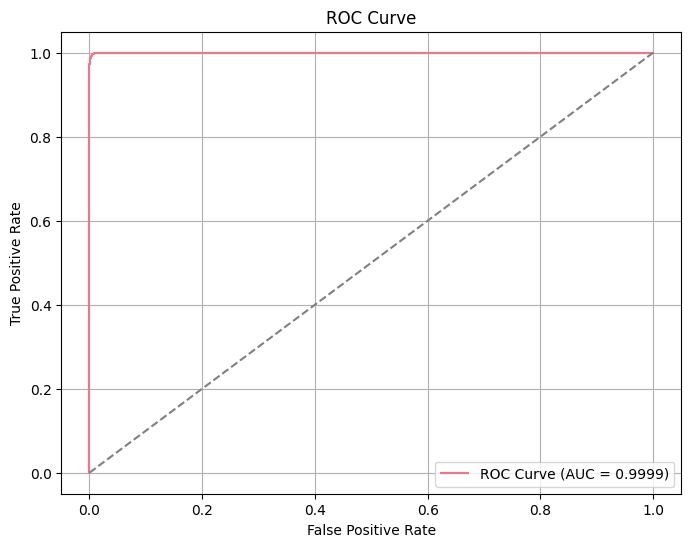

Confusion Matrix:
[[2356   15]
 [  13 4227]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2371
           1       1.00      1.00      1.00      4240

    accuracy                           1.00      6611
   macro avg       1.00      1.00      1.00      6611
weighted avg       1.00      1.00      1.00      6611

Precision: 0.9965
Recall: 0.9969
F1 Score: 0.9967


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# predicting the probabilites
y_probs = model.predict(X_test).ravel()

# get ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# have the probabilities convert to class labels
y_pred = (y_probs > 0.5).astype(int)

# eval
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
